In [20]:
import os
import re
import glob
import numpy as np
from matplotlib import pyplot as plt

In [21]:
data_root_dir = "/global/cfs/projectdirs/m1012/satyarth/Data/ensemble_simulation_runs/ensemble_simulation_run2"
glob_str = f"{data_root_dir}/sim*/separate_2d_layer_info/identity_downsampled/layer7_*.parq"

sim_data = glob.glob(glob_str)

In [ ]:
# sim_pattern = re.compile("/sim[0-9]{1,3}/")

# from collections import Counter
# sorted(Counter([int(sim_pattern.findall(sdi)[0].strip("/").strip("sim")) for sdi in sim_data]).items(), key=lambda x:x[1])

# Dataset Plan
### input
- sim params
- grid_x
- grid_y
- grid_t (time)

### output
- top-view concentration map

# TensorDataset needed!!

In [ ]:
import logging
import pandas as pd
from torch.utils.data import random_split, Dataset, DataLoader, Subset

# THINK: Is it a better idea to downsample on the go?
class SimTopViewLayerDataset(Dataset):
    def __init__(
        self, 
        metadata_csv_path, 
        downsampled=True,
        transform=None, 
        target_transform=None,
        logger_level=logging.WARNING,
    ):
        # Defining logger
        self.logger_ = logging.getLogger(self.__class__.__name__)
        self.logger_.setLevel(logger_level)

        self.metadata_csv_path = metadata_csv_path
        self.metadata_df = pd.read_csv(metadata_csv_path)
        self.metadata_df = self.metadata_df[self.metadata_df["@successful@"]]

        self.ignore_colnames = [
            "@serial_number@",
            "@successful@",
        ]
        self.sim_path_colname = "@sim_path@"
        self.input_param_colnames = [
            "@Perm",
            "@Por@",
            "@alpha@",
            "@Rech@",
            "@seepage@",
        ]
        
        self.downsampled = downsampled
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.metadata_df)
    
    def _point_to_grid(data):
        """Here it is assumed that the data will have x and y downsampled and in integer cartesian coordinates and not the world coordinates. Will need to rescale if it is in world coordinates.
        Proxy for Target Transform.
        TODO: Convert to a transform.

        Args:
            data (pd.DataFrame): DataFrame containing x, y, concentration.

        Returns:
            torch.Tensor: Data grid built from the sparse matrix
        """
        nx = data[:,0].max() - data[:,0].min() + 1
        ny = data[:,1].max() - data[:,1].min() + 1

        data_grid = np.zeros((nx, ny))
        data_grid[:] = np.nan
        data_grid[data[:,1],data[:,0]] = data.values[:,2]
        return data_grid

    def _metadata_to_input(data_meta_row):
        pass

    def __getitem__(self, idx):
        meta_row = self.metadata_df.iloc[idx]

        # input
        input_vals = meta_row[self.input_param_colnames]

        # output
        sim_path = meta_row[self.sim_path_colname]
        data_mode = "identity_downsampled" if self.downsampled else "identity"
        data_path = f"{sim_path}/sim34/separate_2d_layer_info/{data_mode}/layer7_1999y_0000000535c.parq"

        

        # img_path = os.path.join(self.data_dir, self.img_labels[idx])
        # image = torch.from_numpy(np.load(img_path)).unsqueeze(axis=0).float()
        # label = self.img_labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        # return image, label

# IGNORE EVERYTHING BELOW THIS!!!
### Consult [`data_eda.ipynb`](data_eda.ipynb)

In [3]:
inp_path = f"{data_path}/input_top_layer.npy"
inp_data = np.load(inp_path)
inp_data.shape
# 664 simulations
# 24: z
# 257: x
# 11: timestamps
# 11: input variables (more info in meta data)

(664, 24, 257, 11, 11)

In [4]:
output_path = f"{data_path}/output.npy"
output_data = np.load(output_path)
output_data.shape
# 664 simulations
# 24: z
# 257: x
# 11: timestamps
# 7: output variables (more info in meta data)

(664, 24, 257, 11, 7)

# Transformations
Uniform discretization

10m resolution (x-axis)

2.5m resolution (z-axis)

Number of cells for output = $257\times 24$ = ($x\times z$)



In [5]:
# Meta data

meta_path = f"{data_path}/meta_data.txt"
with open(meta_path) as f:
    meta_data = f.readlines()
meta_data = [meta_line.strip().split(", ") for meta_line in meta_data]
meta_data

[['permeability',
  'porosity',
  'alpha',
  'residual water content',
  'm',
  'recharge history',
  'seepage/caprate',
  'seepage concentration'],
 ['1954',
  '1956',
  '1960',
  '1970',
  '1980',
  '1990',
  '2010',
  '2030',
  '2050',
  '2070',
  '2100'],
 ['2.539252000341706e-12',
  '0.3121796200322181',
  '0.000320026752443',
  '0.144001506674446',
  '0.4002490825011002',
  '2.0107818235905494e-06',
  '2.000047811348824e-09',
  '1.0034311621626078e-09'],
 ['7.497679747581689e-12',
  '0.4677607409875378',
  '0.0004799944949573',
  '0.2158411405477249',
  '0.5998631444540116',
  '1.9935183372113407e-05',
  '0.0002498725376145',
  '9.995946889313206e-09'],
 ['darcy_velocity.cell.0',
  'darcy_velocity.cell.1',
  'hydraulic_head.cell.0',
  'pressure.cell.0',
  'saturation_liquid.cell.0',
  'total_component_concentration.cell.Tritium conc',
  'water_content.cell.0']]

In [6]:
inp_vars, time_steps, inp_min, inp_max, output_vars = meta_data

print(f"{len(inp_vars) = }")
print(f"{len(time_steps) = }")
print(f"{len(inp_min) = }")
print(f"{len(inp_max) = }")
print(f"{len(output_vars) = }")

len(inp_vars) = 8
len(time_steps) = 11
len(inp_min) = 8
len(inp_max) = 8
len(output_vars) = 7


In [7]:
print(f"{inp_data.shape = }")
print(f"{output_data.shape = }")


inp_data.shape = (664, 24, 257, 11, 11)
output_data.shape = (664, 24, 257, 11, 7)


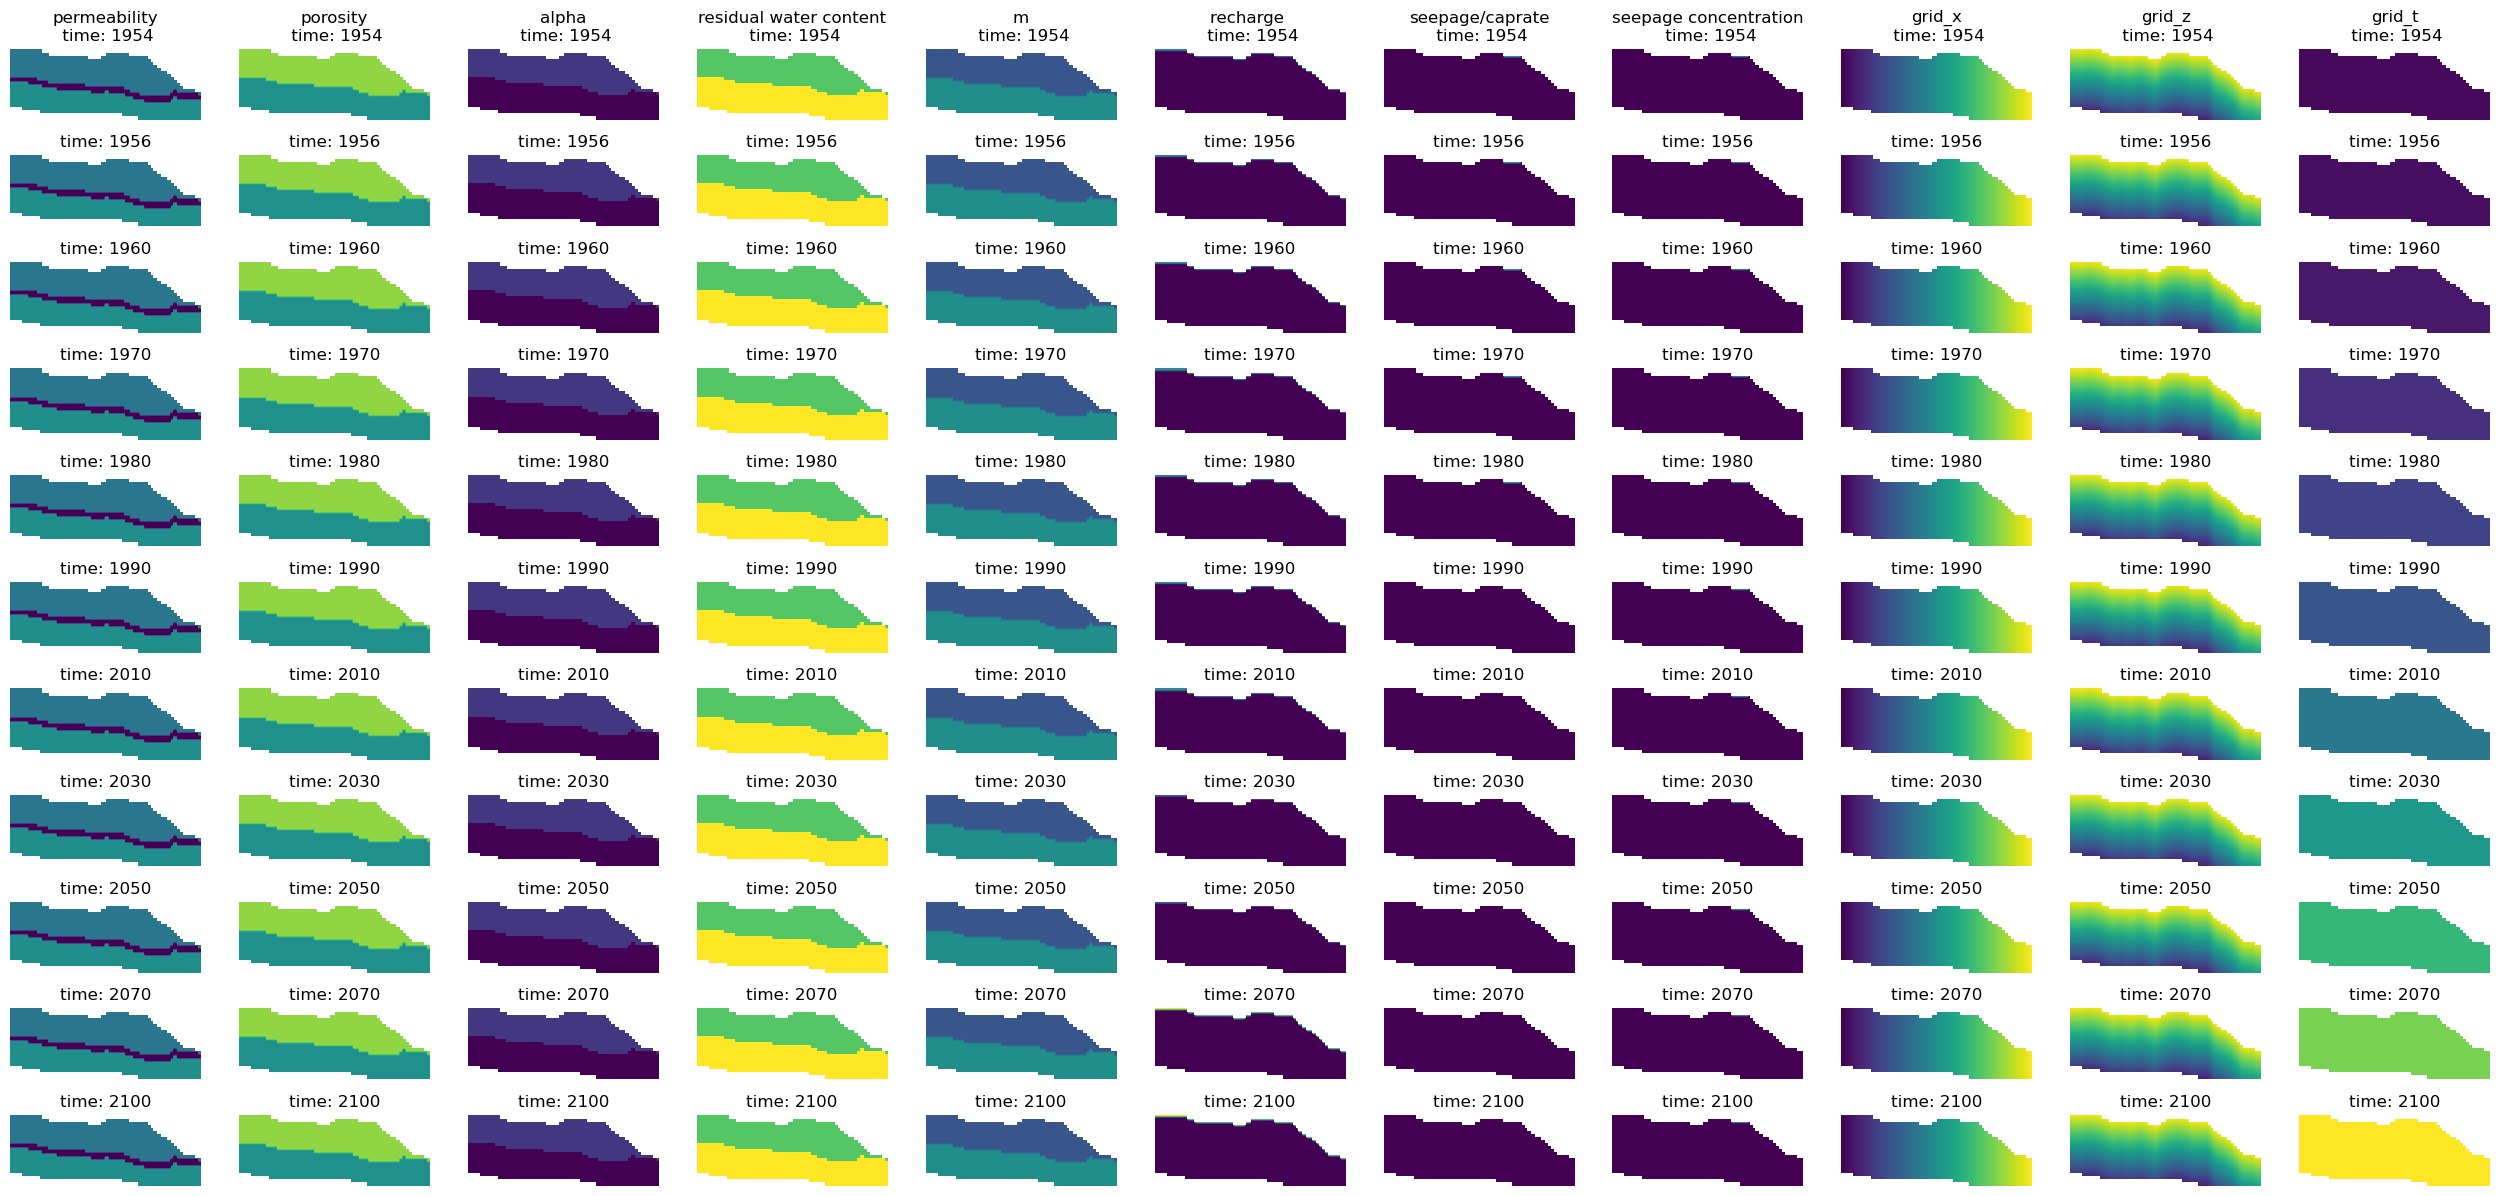

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt

# input visualization
plt.figure(figsize = [32,15])
num_realization = 1

new_name = ['grid_x','grid_z','grid_t']

nt = inp_data.shape[-2]
nc = inp_data.shape[-1] - len(new_name)

for t in np.arange(nt):
    for c in np.arange(inp_data.shape[-1]):
        ax = plt.subplot(nt, nc+3, t*inp_data.shape[-1]+c+1)
        if c < nc: 
            plt.imshow(
                inp_data[num_realization,:,:,t,c],
                vmin = inp_min[c],
                vmax = inp_max[c],
                origin = 'lower',
                aspect = 4,
            )
            if t < 1:
                if c == 5:
                    plt.title('recharge \n time: '+str(int(time_steps[t])))
                else:
                    plt.title(str(inp_vars[c])+'\n time: '+str(int(time_steps[t])))
            else:
                plt.title('time: '+str(int(time_steps[t])))
        else: 
            plt.imshow(
                inp_data[num_realization,:,:,t,c],
                vmin = 0,
                vmax = 1,
                origin = 'lower',
                aspect = 4,
            )
            if t < 1:
                plt.title(str(new_name[c-nc])+'\n time: '+str(int(time_steps[t])))
            else:
                plt.title('time: '+str(int(time_steps[t])))

        plt.axis('off')